In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
import seaborn as sns
import sys
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv("/Users/veera/Data/Repos/Udemy/.dataset/mnist_train.csv", delimiter=',', header=None)
labels = data[0]
data = data.drop(columns=[0])
data = np.array(data)
labels = np.array(labels)

In [3]:
# The min and max values of the data are 0 and 255
# It is normalized to 0 and 1
data_norm = data/np.max(data)
data_tensor = torch.tensor(data_norm).float()
label_tensor = torch.tensor(labels).long()
data_tensor = data_tensor[:20000]

In [5]:
def model():
    class aenet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 150)
            self.enc = nn.Linear(150, 15)
            self.latent = nn.Linear(15, 150)
            self.dec = nn.Linear(150, 784)
        def forward(self, x):
            x = F.relu(self.input(x))
            codex = F.relu(self.enc(x))
            x = F.relu(self.latent(codex))
            y = torch.sigmoid(self.dec(x))
            # we want the output in the same range (normalized as 0 to 1 in the previous step) as the input numerical data
            return y, codex
        
    net = aenet()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, loss_function, optimizer
        


In [6]:
net, lossfn, opt = model()
sample_x = data_tensor[:5]
sample_yhat = net(sample_x)

In [7]:
sample_x.shape

torch.Size([5, 784])

In [9]:
sample_yhat

(tensor([[0.4901, 0.4915, 0.5169,  ..., 0.4984, 0.5317, 0.4963],
         [0.4899, 0.4932, 0.5172,  ..., 0.5013, 0.5368, 0.4960],
         [0.4881, 0.4928, 0.5172,  ..., 0.5004, 0.5351, 0.4991],
         [0.4889, 0.4956, 0.5127,  ..., 0.4958, 0.5263, 0.4983],
         [0.4895, 0.4939, 0.5169,  ..., 0.4980, 0.5303, 0.4979]],
        grad_fn=<SigmoidBackward0>),
 tensor([[0.0000, 0.0000, 0.0000, 0.1016, 0.0000, 0.0803, 0.0000, 0.0000, 0.0379,
          0.0505, 0.1552, 0.0811, 0.0137, 0.0026, 0.0705],
         [0.0000, 0.0570, 0.0000, 0.1617, 0.1438, 0.1304, 0.0253, 0.0000, 0.0664,
          0.0000, 0.0328, 0.0978, 0.0192, 0.0362, 0.1776],
         [0.0000, 0.0000, 0.0000, 0.1169, 0.0958, 0.0751, 0.0276, 0.0000, 0.0413,
          0.0000, 0.0290, 0.0000, 0.0000, 0.0000, 0.0902],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0873, 0.0839, 0.0404, 0.0276, 0.1698,
          0.0414, 0.0811, 0.0370, 0.0019, 0.0000, 0.0117],
         [0.0000, 0.0000, 0.0000, 0.0463, 0.0693, 0.1024, 0.0000, 0.0000,

In [11]:
# output
sample_yhat[0].shape

torch.Size([5, 784])

In [12]:
# output of encoding layer
sample_yhat[1].shape

torch.Size([5, 15])

In [44]:
def train():
    epochs = 10000
    net, loss_function, optimizer = model()
    losses = []
    for i in range(epochs):
        # select a random set of 32 image instead of using minibatch format
        randomidx = np.random.choice(data_tensor.shape[0], size=32)
        x = data_tensor[randomidx,:]
        yhat = net(x)[0]
        loss = loss_function(yhat, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses, net

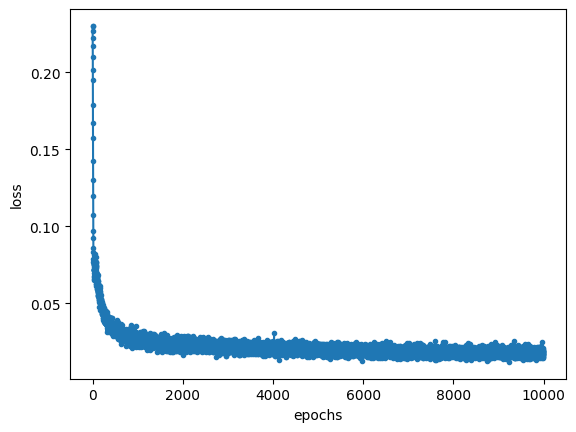

In [45]:
loss, net = train()
plt.plot(loss, '.-')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Inspect the latent code

In [15]:
yhat, latent = net(data_tensor)

In [16]:
yhat.size()

torch.Size([20000, 784])

In [19]:
latent.shape

torch.Size([20000, 15])

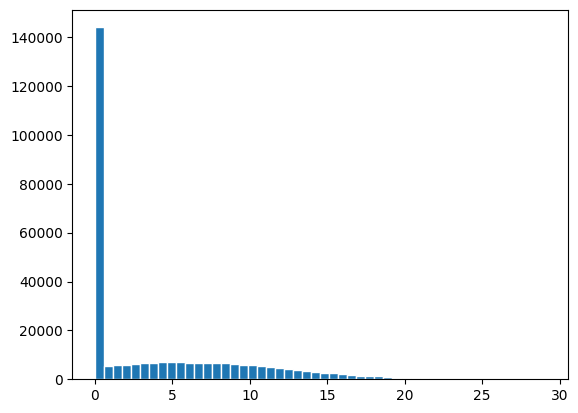

In [25]:
plt.hist(latent.data.flatten(), edgecolor="white", bins=50)
plt.show()

<Axes: >

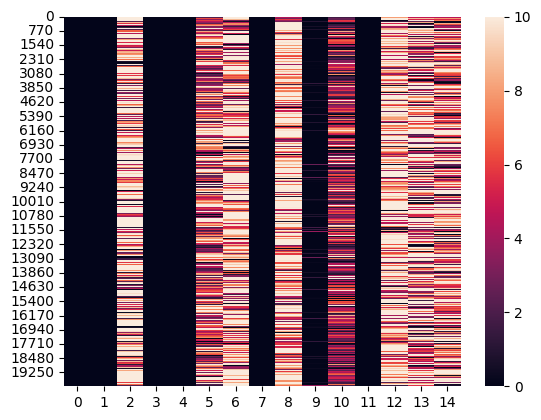

In [29]:
# Some nodes in the latent layer are important and some are set to zero (it is still sparse)
sns.heatmap(latent.detach(), vmax=10, vmin=0)

# PCA

In [33]:
pcadata = PCA(n_components=2).fit(latent.data)

In [38]:
pcadata.explained_variance_ratio_

array([0.31516416, 0.19568154])